# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparatifs](#init)
* [2. Modèles `Bag of words` ou `Bag of N-gram`](#EMBEDDING_BOW)
    * [2.1 `EMB-A0` NN | Ngram=2 | int](#EMBEDDING_BOW_A0)
    * [2.2 `EMB-A1` NN | Ngram=1 | multi_hot](#EMBEDDING_BOW_A1)
    * [2.3 `EMB-A2` NN | Ngram=2 | multi_hot](#EMBEDDING_BOW_A2)
    * [2.4 `EMB-A3` NN | Ngram=2 | count](#EMBEDDING_BOW_A3)
    * [2.5 `EMB-A4` NN | Ngram=2 | tf-idf](#EMBEDDING_BOW_A4)
* [3. Modèles `Séquentiels`](#EMBEDDING_SEQ)
    * [3.1 `EMB-B0` RNN | Ngram=2 | int | One-hot-embedding](#EMBEDDING_SEQ_B0)
    * [3.2 `EMB-B1` RNN | Ngram=2 | int | Keras embedding](#EMBEDDING_SEQ_B1)
    * [3.3 `EMB-B2` RNN | Ngram=2 | int | Keras embedding + MASK](#EMBEDDING_SEQ_B2)
    * [3.4 `EMB-B3` RNN | Ngram=2 | int | Glove 100d + MASK + NOT trainable](#EMBEDDING_SEQ_B3)
    * [3.5 `EMB-B4` RNN | Ngram=1 | int | Glove 100d + MASK + NOT trainable](#EMBEDDING_SEQ_B4)
    * [3.6 `EMB-B5` RNN | Ngram=1 | int | GloveTwitter 25d + MASK + NOT trainable](#EMBEDDING_SEQ_B5)
    * [3.7 `EMB-B6` RNN | Ngram=1 | int | GloveTwitter 100d + MASK + NOT trainable](#EMBEDDING_SEQ_B6)
    * [3.8 `EMB-B7` RNN | Ngram=1 | int | GloveTwitter 200d + MASK + NOT trainable](#EMBEDDING_SEQ_B7)
    * [3.9 `EMB-B8` RNN | Ngram=1 | int | FastText300 + MASK + NOT trainable](#EMBEDDING_SEQ_B8)
    * [3.10 `EMB-B9` RNN | Ngram=1 | int | Word2Vec300_GoogleNews + MASK + NOT trainable](#EMBEDDING_SEQ_B9)
* [4. Modèles `classiques` pour comparaison](#NO_EMBEDDING)
    * [4.1 `EMB-C0` LogisticRegression | TfidVectorize](#NO_EMBEDDING_C0)
* [5. Comparaison des scores](#EMBEDDING_scores)

In [1]:
import os
import time
import pathlib
import gzip

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dagshub import dagshub_logger, DAGsHubLogger

try:
    from tensorflow.keras.layers import TextVectorization
except ImportError:
    from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# set random seed for reproductibility
random_seed = 0
np.random.seed(random_seed)

try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

2022-08-08 21:33:47.518744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 21:33:47.518769: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2022-08-08 21:33:49.583182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-08 21:33:49.583208: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-08 21:33:49.583229: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (valkea-XPS): /proc/driver/nvidia/version does not exist


---
---
# 1. Préparatifs pour de la classification avec des réseaux de neurones <a class="anchor" id="init"></a> [⇪](#menu)

### Chargeons quelques fonctions *maison* pour entrainer et évaluer les modèles, et initialisons un fichier pour enregistrer les scores
Ces fonctions ont été déportées dans le fichier classification_utils.py pour allèger le notebook

In [3]:
from classification_utils import fit_model, get_scores, init_scores, find_best_threshold
init_scores("data/scores_NN_SelectEmbedding.csv")

### Chargeons le jeu de données et préparons un `échantillon de travail` représentatif

In [4]:
data_work = pd.read_csv(
    pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_1563108.csv'), 
    usecols=['target', 'lemmas_not_filtered'],
    encoding='ISO-8859-1',
    #nrows=100000,
)
data_work.rename(columns={'lemmas_not_filtered':'text'}, inplace=True)
display(data_work.head(), data_work.shape)

# Select samples
sample_size = 100000
data_work = data_work.groupby('target', group_keys=False).apply(lambda x: x.sample(sample_size//2, random_state=random_seed))
display(data_work.head(), data_work.shape)

,target,text
0,0,"$ url$ - awww , that be a bummer . you shoulda..."
1,0,be upset that he can not update his facebook b...
2,0,I dive many time for the ball . manage to save...
3,0,my whole body feel itchy and like its on fire
4,0,"no , it be not behave at all . I be mad . why ..."


(1452791, 2)

,target,text
469259,0,I do not have a background for my twitter stre...
152271,0,I do many thing but miss tweet
597612,0,most probably - eww all that pasty white skin ...
708306,0,"ohh , how bad I sleep"
59100,0,"hell yeah u be texte I I remember , I be at my..."


(100000, 2)

In [5]:
data_work.target.value_counts(dropna=False)

0    50000
1    50000
Name: target, dtype: int64

### Définissons les différentes `architectures` dont nous allons avoir besoin

In [6]:
def architecture001(f_opti, f_loss, f_metrics, max_tokens=20000, hidden_dim=16):
        
    inputs = keras.Input(shape=(max_tokens,), dtype="int64")
    
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, f"Dense {hidden_dim} + Dropout 0.5"

In [7]:
def architecture002_oh(f_opti, f_loss, f_metrics, voc_size):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = tf.one_hot(inputs, depth=voc_size)
    x = layers.Bidirectional(layers.LSTM(32))(x) # 64
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "one_hot + Bi-LSTM 32 + Dropout 0.5"

In [8]:
def architecture002(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(x) # 64
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 32 + Dropout 0.5"

In [9]:
def architecture003(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(24, activation='relu')(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 64 + Dense 24"

### Définissons les fonctions utiles à l'`embedding`

In [10]:
from gensim.models import KeyedVectors
import gensim.downloader as api

def load_gensim_embedding(embedding_name, binary=False):
    
    embedding_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'embedding_models', f'{embedding_name}.gz')
    try:
        if embedding_path.is_file():
            print(f"Loading from {embedding_path}")
            embedding_model = KeyedVectors.load_word2vec_format(embedding_path, binary=binary)
        else:
            print("Loading from the Git repos with API")
            embedding_model = api.load(embedding_name)
            
        return embedding_model
    except Exception as e:
        print(f"The provided embedding model couldn't be loaded correctly: {e}")
        
def load_trained_glove(embedding_name):
    
    def parse_file(file):
        embeddings_index = {}
        for line in file:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
        return embeddings_index

    try:
        embedding_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'embedding_models', f'{embedding_name}.gz')
        if embedding_path.is_file():
            print(f"Loading from gZip: {embedding_path}")
            with gzip.open(embedding_path, mode='rt') as f:
                return parse_file(f)
        
        embedding_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'embedding_models', f'{embedding_name}.txt')
        if embedding_path.is_file():
            print(f"Loading from TXT: {embedding_path}")
            with open(embedding_path) as f:
                return parse_file(f)
        else:
            raise FileNotFoundError(f"No such model found (it must be {embedding_name}.txt or {embedding_name}.gz)")
            
    except Exception as e:
        print(f"The provided embedding model couldn't be loaded correctly: {e}")

In [11]:
def convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim=100):
    
    hits = 0
    misses = 0
    misses_list = []
    
    word_index = dict(zip(vocabulary, range(len(vocabulary))))
    
    embedding_matrix = np.zeros((max_tokens, embedding_dim))
    
    for word, i in word_index.items():
        if i < max_tokens:
            try:
                embedding_vector = embeddings_index.get_vector(word)
            except AttributeError:
                embedding_vector = embeddings_index.get(word)
            except KeyError:
                embedding_vector = None
        if embedding_vector is not None:
            hits += 1
            embedding_matrix[i] = embedding_vector
        else:
            misses += 1
            misses_list.append(word)
            
    print(f"Converted {hits} words, and couldn't find {misses} words")
    print(f"Missing words: {misses_list}")
            
    return embedding_matrix

### Définissons les `fonctions et paramètres commun` à l'entrainement des différents modèles que l'on veut tester

In [12]:
# DagsHub 

def save_hyperparameters_to_dagshub(dlogger, model_name, archi_desc, layers, batch_size, sample_size):    
    dlogger.log_hyperparams(model_name=model_name)
    dlogger.log_hyperparams(archi_desc=archi_desc)
    dlogger.log_hyperparams(layers=layers)
    dlogger.log_hyperparams(batch_size=batch_size)
    dlogger.log_hyperparams(sample_size=sample_size)
    
def save_metrics_to_dagshub(dlogger, scores, best_threshold, history, step_num=1000, close=True):
    dlogger.log_metrics(scores, step_num=step_num)
    dlogger.log_metrics(best_threshold=best_threshold, step_num=step_num)
    add_scores_to_dagshub(dlogger, history)

def get_layers_for_dagshub(model):
    
    layers_infos = []
    
    def search(layer):
        layer = dict(layer)
        
        nonlocal layers_infos
        
        if 'config' in layer:
    
            #if 'name' in layer['config']:
            #    print(" name:", layer['config']['name'])
            conf = {}
            if 'units' in layer['config']:
                conf["units"] = layer['config']['units']
            if 'output_dim' in layer['config']:
                conf['output_dim'] = layer['config']['output_dim']
            if 'rate' in layer['config']:
                conf['rate'] = layer['config']['rate']
            
            layers_infos.append((layer['class_name'], conf))
            
            if 'layer' in layer['config']:
                search(layer['config']['layer'])
        
    for layer in model.get_config()['layers']:
        search(layer)
        
    return layers_infos


def add_scores_to_dagshub(dlogger, history):
    for epoch, loss, accuracy, val_loss, val_accuracy in zip(
        history.epoch, 
        history.history['loss'], 
        history.history['accuracy'], 
        history.history['val_loss'], 
        history.history['val_accuracy']):
        scores = {
            'loss':loss, 
            'accuracy':accuracy, 
            'val_loss':val_loss, 
            'val_accuracy':val_accuracy
        }
        dlogger.log_metrics(scores, step_num=epoch) 

In [13]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [14]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.keras")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=5,
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )
    
    return [checkpoint, es]

In [15]:
batch_size=1024

### Divisons le jeu de données en `Train`, `Valid` et `Test` sets

In [16]:
X_train_full, X_test, y_train_full, y_test = train_test_split(data_work['text'], data_work['target'], test_size=0.2, random_state=random_seed, stratify=data_work['target'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=X_test.shape[0], random_state=random_seed, stratify=y_train_full)

assert X_train.shape[0] + X_valid.shape[0] + X_test.shape[0] == data_work.shape[0]
assert y_train.shape[0] + y_valid.shape[0] + y_test.shape[0] == data_work.shape[0]

print(f"X_train: {X_train.shape} + X_valid: {X_valid.shape} + X_test: {X_test.shape}")
print(f"y_train: {X_train.shape} + y_valid: {X_valid.shape} + y_test: {X_test.shape}")

X_train: (60000,) + X_valid: (20000,) + X_test: (20000,)
y_train: (60000,) + y_valid: (20000,) + y_test: (20000,)


### Préparons les différentes version du text_vectorizer que l'on veut tester

In [17]:
text_dataset = tf.data.Dataset.from_tensor_slices(list(data_work.text)) 

2022-08-08 21:33:55.070167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
text_vectorization0 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    output_sequence_length=79 # search the max size by default
)

In [19]:
text_vectorization0.adapt(text_dataset.batch(batch_size), True)

In [20]:
text_vectorization1 = TextVectorization(
    output_mode='multi_hot', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=1,
    # output_sequence_length=60 # search the max size by default
)

In [21]:
text_vectorization1.adapt(text_dataset.batch(batch_size), True)

In [22]:
text_vectorization2 = TextVectorization(
    output_mode='multi_hot', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    # output_sequence_length=60 # search the max size by default
)

In [23]:
text_vectorization2.adapt(text_dataset.batch(batch_size), True)

In [24]:
text_vectorization3 = TextVectorization(
    output_mode='count', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    # output_sequence_length=60 # search the max size by default
)

In [25]:
text_vectorization3.adapt(text_dataset.batch(batch_size), True)

In [26]:
text_vectorization4 = TextVectorization(
    output_mode='tf_idf', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    # output_sequence_length=60 # search the max size by default
)

In [27]:
text_vectorization4.adapt(text_dataset.batch(batch_size), True)

In [28]:
max_length = 60
max_tokens = 20000

text_vectorizationBng2= TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=2,
    output_sequence_length=max_length # search the max size by default
)

In [29]:
text_vectorizationBng2.adapt(text_dataset.batch(batch_size), True)

In [30]:
max_length = 60
max_tokens = 20000

text_vectorizationBng1= TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [31]:

text_vectorizationBng1.adapt(text_dataset.batch(batch_size), True)

---
---
# 2. Recherche de l'`embedding` le plus adapté avec des modèles `Bag of words` ou `Bag of N-gram` <a class="anchor" id="EMBEDDING_BOW"></a> [⇪](#menu)

---
## 2.1 `EMB-A0` NN | Ngram=2 | int <a class="anchor" id="EMBEDDING_BOW_A0"></a> [⇪](#menu)

### Standardize & Tokenize

In [32]:
# Done before
print(text_vectorization0.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that'] ...


### Prepare dataset

In [33]:
X_train_ready = text_vectorization0(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorization0(X_test)

In [34]:
X_train[:2]

888559               dh way too crazy ... I need a xanax ..
500657    I too ... bur with engineering imma be here 5 ...
Name: text, dtype: object

In [35]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 79), dtype=int64, numpy=
array([[11160,   154,    54,   652,     2,    89,     6,     1,     1,
         2155,     1,  8016,   210,   598,     1,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    2,    54,     1,    26,     1,  2574,     3,   104,   382,
         1806,   874,   886,     1,     1,     1,     1,     1,   762,
            1,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0, 

### Define model

In [36]:
model_name = "EmbedA0"
model, archi_desc = architecture001("adam", "binary_crossentropy", ['accuracy'], X_train_ready[:0].shape[1])
archi_desc = "No Embedding + Bigrams | " + archi_desc

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 79)]              0         
                                                                 
 dense (Dense)               (None, 16)                1280      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 predictions (Dense)         (None, 1)                 17        
                                                                 
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


#### Définissons un logger DagsHub pour enregistrer notre essai

In [38]:
dagslogger = DAGsHubLogger()

In [39]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [40]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
51/59 [========================>.....] - ETA: 0s - loss: 1080.4668 - accuracy: 0.4981
Epoch 1: val_accuracy improved from -inf to 0.49435, saving model to models/EmbedA0.keras
59/59 [==============================] - 1s 7ms/step - loss: 1036.2001 - accuracy: 0.4967 - val_loss: 402.5112 - val_accuracy: 0.4943
Epoch 2/50
57/59 [===========================>..] - ETA: 0s - loss: 448.6161 - accuracy: 0.5021
Epoch 2: val_accuracy improved from 0.49435 to 0.49870, saving model to models/EmbedA0.keras
59/59 [==============================] - 0s 4ms/step - loss: 444.0706 - accuracy: 0.5020 - val_loss: 187.9163 - val_accuracy: 0.4987
Epoch 3/50
58/59 [============================>.] - ETA: 0s - loss: 184.3248 - accuracy: 0.5016
Epoch 3: val_accuracy improved from 0.49870 to 0.49975, saving model to models/EmbedA0.keras
59/59 [==============================] - 0s 4ms/step - loss: 183.4619 - accuracy: 0.5017 - val_loss: 83.9152 - val_accuracy: 0.4997
Epoch 4/50
59/59 [==================

### Evaluate

In [41]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [42]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 1s 1ms/step - loss: 2.0043 - accuracy: 0.5138


[2.004340410232544, 0.5138000249862671]

In [43]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorization0(raw_txt)
model.predict(raw_txt)

1/1 [==============================] - 0s 76ms/step


array([[0.49982384],
       [0.48310518]], dtype=float32)

625/625 [==============================] - 1s 1ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- EmbedA0 ----------------------------------------------------------------------------------------

             ROC_AUC : 0.5150
                  F1 : 0.5391
            ACCURACY : 0.5138
           PRECISION : 0.5124
              RECALL : 0.5688
   AVERAGE_PRECISION : 0.5077

       TRAINING-TIME : 10.9206
      INFERENCE-TIME : 0.9651

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.52      0.46      0.49     10000
Prediction = 1       0.51      0.57      0.54     10000

      accuracy        

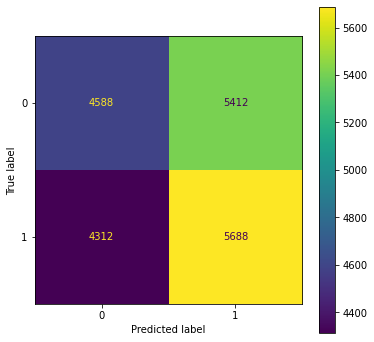

--- ROC AUC ---------------------------------------------------------------------------------------- 



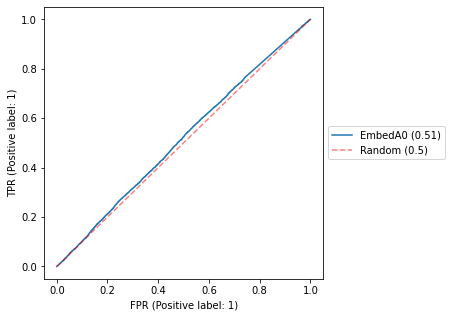

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



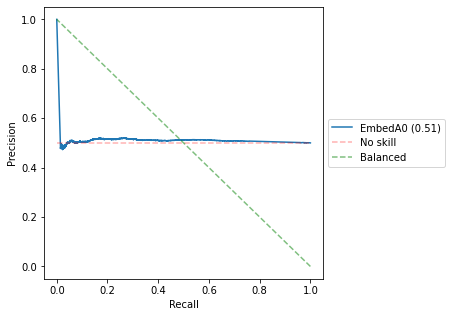

In [44]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [45]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

625/625 [==============================] - 1s 1ms/step
The best Accuracy score (0.5102) for this model is reached with a threshold of 0.514


625/625 [==============================] - 1s 1ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- EmbedA0 [w. threshold] -------------------------------------------------------------------------

             ROC_AUC : 0.5150
                  F1 : 0.5004
            ACCURACY : 0.5115
           PRECISION : 0.5121
              RECALL : 0.4893
   AVERAGE_PRECISION : 0.5077

       TRAINING-TIME : 10.9206
      INFERENCE-TIME : 0.9399

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.51      0.53      0.52     10000
Prediction = 1       0.51      0.49      0.50     10000

      accuracy        

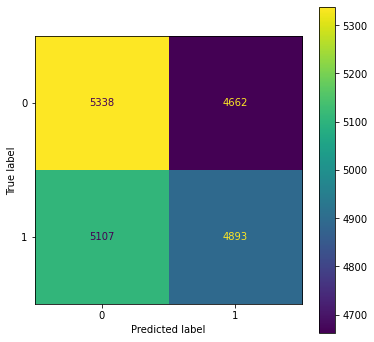

In [46]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [47]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [48]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,EmbedA0,0.500,None,0.514969,0.507741,0.539147,0.51380,0.512432,0.5688,5688,4588,5412,4312,10.920612,0.965077
1,EmbedA0 [w. threshold],0.514,None,0.514969,0.507741,0.500435,0.51155,0.512088,0.4893,4893,5338,4662,5107,10.920612,0.939870


---
## 2.2 `EMB-A1` NN | Ngram=1 | multi_hot <a class="anchor" id="EMBEDDING_BOW_A1"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorization1.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorization1(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorization1(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Define model

In [ ]:
model_name = "EmbedA1"
model, archi_desc = architecture001("adam", "binary_crossentropy", ['accuracy'], X_train_ready[:0].shape[1])
archi_desc = "No Embedding + Unigrams | " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorization1(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.3 `EMB-A2` NN | Ngram=2 | multi_hot <a class="anchor" id="EMBEDDING_BOW_A2"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorization2.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorization2(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorization2(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Define model

In [ ]:
model_name = "EmbedA2"
model, archi_desc = architecture001("adam", "binary_crossentropy", ['accuracy'], X_train_ready[:0].shape[1])
archi_desc = "No Embedding + Bigrams | " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorization2(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.4 `EMB-A3` NN | Ngram=2 | count <a class="anchor" id="EMBEDDING_BOW_A3"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorization3.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorization3(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorization3(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Define model

In [ ]:
model_name = "EmbedA3"
model, archi_desc = architecture001("adam", "binary_crossentropy", ['accuracy'], X_train_ready[:0].shape[1])
archi_desc = "No Embedding + Bigrams | " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorization3(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.5 `EMB-A4` NN | Ngram=2 | tf-idf <a class="anchor" id="EMBEDDING_BOW_A4"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorization4.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorization4(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorization4(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Define model

In [ ]:
model_name = "EmbedA4"
model, archi_desc = architecture001("adam", "binary_crossentropy", ['accuracy'], X_train_ready[:0].shape[1])
archi_desc = "No Embedding + Bigrams | " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorization4(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
---
# 3. Recherche de l'`embedding` le plus adapté avec des modèles `Séquentiels` <a class="anchor" id="EMBEDDING_SEQ"></a> [⇪](#menu)

---
## 3.1 `EMB-B0` RNN | Ngram=2 | int | One-hot-embedding <a class="anchor" id="EMBEDDING_SEQ_B0"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorizationBng2.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorizationBng2(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorizationBng2(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Define model

In [ ]:
model_name = "EmbedB0"
model, archi_desc = architecture002_oh("adam", "binary_crossentropy", ['accuracy'], max_tokens)
archi_desc = "One-Hot Embedding layer + Bigrams | " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationBng2(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 3.2 `EMB-B1` RNN | Ngram=2 | int | Keras embedding <a class="anchor" id="EMBEDDING_SEQ_B1"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorizationBng2.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorizationBng2(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorizationBng2(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Embedding

In [ ]:
# Embedding simple
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=128, 
    input_length=X_train_ready.shape[1],
    # mask_zero=True,
    # trainable=True, # <== default is True
)

### Define model

In [ ]:
model_name = "EmbedB1"
model, archi_desc = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)
archi_desc = "Keras Embedding + Bigrams | " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationBng2(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 3.3 `EMB-B2` RNN | Ngram=2 | int | Keras embedding + MASK <a class="anchor" id="EMBEDDING_SEQ_B2"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorizationBng2.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorizationBng2(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorizationBng2(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Embedding

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=128, 
    input_length=X_train_ready.shape[1],
    mask_zero=True,
    # trainable=True, # <== default is True
)

### Define model

In [ ]:
model_name = "EmbedB2"
model, archi_desc = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)
archi_desc = "Keras Embedding + MASK + Bigrams | " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationBng2(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 3.4 `EMB-B3` RNN | Ngram=2 | int | Glove 100d + MASK + NOT trainable <a class="anchor" id="EMBEDDING_SEQ_B3"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorizationBng2.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorizationBng2(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorizationBng2(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Embedding

In [ ]:
embeddings_index = load_trained_glove("glove.6B.100d")

In [ ]:
embedding_dim = 100
vocabulary = text_vectorizationBng2.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

### Define model

In [ ]:
model_name = "EmbedB3"
model, archi_desc = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)
archi_desc = "GloVe 100d + MASK + NT + Bigrams| " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationBng2(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 3.5 `EMB-B4` RNN | Ngram=1 | int | Glove 100d + MASK + NOT trainable <a class="anchor" id="EMBEDDING_SEQ_B4"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorizationBng1.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorizationBng1(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorizationBng1(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Embedding

In [ ]:
embeddings_index = load_trained_glove("glove.6B.100d")

In [ ]:
embedding_dim = 100
vocabulary = text_vectorizationBng1.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

### Define model

In [ ]:
model_name = "EmbedB4"
model, archi_desc = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)
archi_desc = "GloVe 100d + MASK + NT + Unigrams| " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationBng1(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 3.6 `EMB-B5` RNN | Ngram=1 | int | GloveTwitter 25d + MASK + NOT trainable <a class="anchor" id="EMBEDDING_SEQ_B5"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorizationBng1.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorizationBng1(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorizationBng1(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Embedding

In [ ]:
embeddings_index = load_gensim_embedding("glove-twitter-25")

In [ ]:
embedding_dim = 25
vocabulary = text_vectorizationBng1.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

### Define model

In [ ]:
model_name = "EmbedB5"
model, archi_desc = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)
archi_desc = "GloVeTwitter 25d + MASK + NT + Unigrams| " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationBng1(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 3.7 `EMB-B6` RNN | Ngram=1 | int | GloveTwitter 100d + MASK + NOT trainable <a class="anchor" id="EMBEDDING_SEQ_B6"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorizationBng1.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorizationBng1(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorizationBng1(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Embedding

In [ ]:
embeddings_index = load_gensim_embedding("glove-twitter-100")

In [ ]:
embedding_dim = 100
vocabulary = text_vectorizationBng1.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

### Define model

In [ ]:
model_name = "EmbedB6"
model, archi_desc = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)
archi_desc = "GloVeTwitter 100d + MASK + NT + Unigrams| " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationBng1(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 3.8 `EMB-B7` RNN | Ngram=1 | int | GloveTwitter 200d + MASK + NOT trainable <a class="anchor" id="EMBEDDING_SEQ_B7"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorizationBng1.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorizationBng1(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorizationBng1(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Embedding

In [ ]:
embeddings_index = load_gensim_embedding("glove-twitter-200")

In [ ]:
embedding_dim = 200
vocabulary = text_vectorizationBng1.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

### Define model

In [ ]:
model_name = "EmbedB7"
model, archi_desc = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)
archi_desc = "GloVeTwitter 200d + MASK + NT + Unigrams| " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationBng1(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 3.9 `EMB-B8` RNN | Ngram=1 | int | FastText300 + MASK + NOT trainable <a class="anchor" id="EMBEDDING_SEQ_B8"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorizationBng1.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorizationBng1(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorizationBng1(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Embedding

In [ ]:
embeddings_index = load_gensim_embedding("fasttext-wiki-news-subwords-300")

In [ ]:
embedding_dim = 300
vocabulary = text_vectorizationBng1.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

### Define model

In [ ]:
model_name = "EmbedB8"
model, archi_desc = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)
archi_desc = "FastText 300d + MASK + NT + Unigrams| " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationBng1(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 3.10 `EMB-B9` RNN | Ngram=1 | int | Word2Vec300_GoogleNews + MASK + NOT trainable <a class="anchor" id="EMBEDDING_SEQ_B9"></a> [⇪](#menu)

### Standardize & Tokenize

In [ ]:
# Done before
print(text_vectorizationBng1.get_vocabulary()[:20], "...")

### Prepare dataset

In [ ]:
X_train_ready = text_vectorizationBng1(X_train)
X_valid_ready = text_vectorization0(X_valid)
X_test_ready = text_vectorizationBng1(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Embedding

In [ ]:
embeddings_index = load_gensim_embedding("word2vec-google-news-300", binary=True)

In [ ]:
embedding_dim = 300
vocabulary = text_vectorizationBng1.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

### Define model

In [ ]:
model_name = "EmbedB9"
model, archi_desc = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)
archi_desc = "Word2Vec 300d google + MASK + NT + Unigrams| " + archi_desc

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationBng1(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
---
# 4. Modèle `classiques` (pour comparaison) <a class="anchor" id="NO_EMBEDDING"></a> [⇪](#menu)

---
## 4.1 `EMB-C0` LogisticRegression | RAW_lemmas_not_filtered <a class="anchor" id="NO_EMBEDDING_C0"></a> [⇪](#menu)

In [ ]:
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

### Préparons le jeu de données en `Train` et `Test` sets

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare TF-IDF 
tfidf_vectorizer_train = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.5) #, max_features=2000)
X_train_ready = tfidf_vectorizer_train.fit_transform(X_train)
X_test_ready = tfidf_vectorizer_train.transform(X_test)

In [ ]:
print(f"TF-IDF features: {tfidf_vectorizer_train.get_feature_names_out()}")
print(f"Sets shapes >> X_train_ready: {X_train_ready.shape}, X_test_ready: {X_test_ready.shape}")

### Appliquons la Logistic Regression avec ce jeu de données

In [ ]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, loguniform

In [ ]:
max_lr_iter = 3000
param_grid = [
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['saga'],
        'penalty' : ['elasticnet'], # none
        'C' : loguniform(1e-5, 1e2),
        'l1_ratio' : uniform(0,1)
    },
]

In [ ]:
model_name = "Test C00"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train_ready,
    y_ref = y_train,
)

### Evaluate

In [ ]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test_ready, y_ref=y_test)

---
---
# 5. Comparaison des `scores` <a class="anchor" id="EMBEDDING_scores"></a> [⇪](#menu)

In [ ]:
from classification_utils import scores_df

In [ ]:
scores_df

In [ ]:
scores_df.sort_values(['ROC AUC'], ascending=False)